In [1]:
from __future__ import print_function
import os
import cv2
import numpy as np
import csv
from PIL import Image
from matplotlib import pyplot as plt

#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVC
from sklearn.decomposition import PCA

#from sklearn.metrics import accuracy_score
from math import hypot

import numba
from numba import jit, cuda 

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

#import tensorflow.keras
#from keras.utils import to_categorical

In [2]:
def edit_csvfiles(directory):
    inputfile = csv.reader(open(directory + '\\DefectResult.csv','r'))
    outputfile = open(directory + '\\DefectResult_edited.csv','w')
    i=0
    for row in inputfile:
        for i in range(0, len(row)):
            if i == 5:
                attributes = row[i].replace('Bottom','Bottom,\n')
                outputfile.write(attributes)
                outputfile.write(",")
                continue
            outputfile.write(row[i])
            outputfile.write(",")
        outputfile.write("\n")

In [3]:
@jit
def old_mask(img):
    bad = False
    #img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    #                 CROP
    x_start = 50
    y_start = 50
    crop_img = img[y_start:y_start+1255, x_start:x_start+1250]
    #                 RESIZE CROPPED
    scale_percent = 60
    width = int(crop_img.shape[1] * scale_percent / 100)
    height = int(crop_img.shape[0] * scale_percent / 100)
    dsize = (width, height)
    img = cv2.resize(crop_img, dsize)

    img = cv2.medianBlur(img,5)
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 400, param1=50, param2=25, minRadius=150, maxRadius=0)

    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)


    #print("width, height", width, height)
    x, y, r = circles[0,:][0]
    
    if x<width*0.35 or x > width*0.65 or y<height*0.35 or y > height*0.65:
        print("x,y:",x,y)
        bad = True
        plt.imshow(cimg, cmap = 'gray', interpolation = 'bicubic')
        plt.show()
        
    rows, cols = img.shape

    for i in range(cols):
        for j in range(rows):
            if hypot(i-x, j-y) > r:
                img[j,i] = 0
                
    #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    #plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    #plt.show()
    
    return img, bad

In [4]:
@jit
def load_images_from_folder(folder, key):
    listofFiles = os.listdir(folder)
    
    for filename in listofFiles:
        joinedFilePath = os.path.join(folder,filename)
        if key =="RGB":
            img = cv2.imread(joinedFilePath)
        elif key == "Grayscale":
            img = cv2.imread(joinedFilePath, 0)
        if img is not None and filename == "PRT_000001_L1.jpg":
            img, bad = old_mask(img)
            print("Loaded image from", folder)
            
            return img, bad

In [5]:
def rotate(image, angle, scale=1.0):
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv2.warpAffine(image,M,(w,h))
        return image

In [6]:
def flip(image, vflip, hflip):
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 

In [7]:
def get_labels(folder):
    defect = "불량" #1
    reserved = "보류" #2
    normal = "정상" #0
    target = folder + "\\" + 'DefectResult_edited.csv'
    label = "N/A"
    
    if os.path.exists(target):
        with open(target) as fin:
            reader = csv.reader(fin)
            next(reader)
            for row in reader:
                if defect in row[1:2]:
                    label = 1 # 2 to 1
                    break
                elif reserved in row:
                    label = 2 #1 to 2
                elif normal in row:
                    label = 0         
    else:
        print("DefectResult_edited.csv was not found in ", folder)

    return label

In [8]:
@jit
def getImagesandLabels(path, folders):

    images = []
    labels = []
    folder= path

    for i in range(0, len(folders)):
        folder= path + "\\" + folders[i]
        #edit_csvfiles(folder) #run once only
        result,bad = load_images_from_folder(folder, "Grayscale") #choose "RGB" or "Grayscale"
        the_label = get_labels(folder)
        if (the_label == 2):
            continue
        if (bad ==True):
            print("BAD IMAGE")
            continue
        images.append(result)
        labels.append(the_label)
        
        if the_label == 2:            
            images.append(rotate(result, angle=90, scale=1.0))
            labels.append(the_label)

            images.append(rotate(result, angle=180, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=270, scale=1.0))
            labels.append(the_label)
            
        if the_label == 1:
            images.append(rotate(result, angle=22.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=45, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=67.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=90, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=112.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=135, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=157.5, scale=1.0))
            labels.append(the_label)

            images.append(rotate(result, angle=180, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=202.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=225, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=247.5, scale=1.0))
            labels.append(the_label)

            images.append(rotate(result, angle=270, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=292.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=315, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=337.5, scale=1.0))
            labels.append(the_label)
            
            images.append(flip(result, vflip=True, hflip=False))
            labels.append(the_label)

            images.append(flip(result, vflip=False, hflip=True))
            labels.append(the_label)
        
        elif the_label==0:
            images.append(rotate(result, angle=90, scale=1.0))
            labels.append(the_label)

            images.append(rotate(result, angle=180, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=270, scale=1.0))
            labels.append(the_label)
            
            images.append(flip(result, vflip=True, hflip=False))
            labels.append(the_label)

            images.append(flip(result, vflip=False, hflip=True))
            labels.append(the_label)
    
    return images, labels

In [9]:
@jit
def preprocess_XY(images, labels):
    print("############# OVERALL ################")
    defectcount = reservedcount = normalcount = 0
    for element in labels:
        if element == 1:
            defectcount +=1
        elif element == 2:
            reservedcount+=1
        elif element == 0:
            normalcount +=1
    print("불량 갯수:", defectcount)
    print("보류 갯수:", reservedcount)
    print("정상 갯수:", normalcount)
    print()
    
    images = np.asarray(images)
    labels = np.asarray(labels)
    
    splitter =int(len(images)*.75)
    x_train = images[0:splitter]
    x_test = images[splitter:len(images)]
    y_train = labels[0:splitter]
    y_test = labels[splitter:len(labels)]
    
    mult = images[0].shape[0] * images[0].shape[1]
    print("n pixels:", mult)

    x_train = x_train.reshape(len(x_train), mult)
    x_test = x_test.reshape(len(x_test), mult)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = x_train / 255.0*100 - 50
    x_test = x_test / 255.0*100 - 50
    #y_train = y_train % 2
    #y_test = y_test % 2
    
    pca = PCA(n_components=70)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)

    #from keras.utils import to_categorical
    #y_train = to_categorical(y_train, num_classes = 2) #change 
    #y_test = to_categorical(y_test, num_classes = 2) #change
    
    
    return x_train, y_train, x_test, y_test

Files and Directories in 'C:\Users\main\AllLenses\Allframedata1'


<ipython-input-8-a75cd4c4e8a5>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "getImagesandLabels" failed type inference due to: Untyped global name 'get_labels': Cannot determine Numba type of <class 'function'>

File "<ipython-input-8-a75cd4c4e8a5>", line 12:
def getImagesandLabels(path, folders):
    <source elided>
        result,bad = load_images_from_folder(folder, "Grayscale") #choose "RGB" or "Grayscale"
        the_label = get_labels(folder)
        ^

  @jit
<ipython-input-8-a75cd4c4e8a5>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "getImagesandLabels" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-8-a75cd4c4e8a5>", line 8:
def getImagesandLabels(path, folders):
    <source elided>

    for i in range(0, len(folders)):
    ^

  @jit
C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packa

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000000
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000001
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000002
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000003
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000004
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000005
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000006
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000007
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000008
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000009
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000010
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000011
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000012
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000013
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000014
Loaded image from C:\User

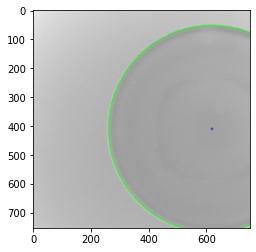

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000072
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000073
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000074
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000075
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000076
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000077
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000078
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000079
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000081
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000082
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000083
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000084
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000085
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000086
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000087
Loaded image fr

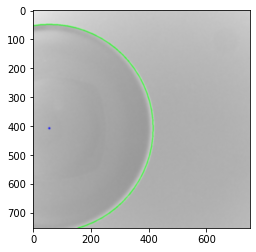

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000103
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000104
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000105
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000106
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000107
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000108
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000109
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000110
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000111
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000112
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000113
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000114
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000115
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000116
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000117
Loaded image fr

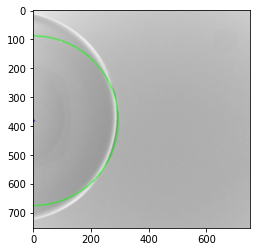

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000122
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000123
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000124
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000125
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000126
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000127
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000128
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000129
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000130
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000131
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000132
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000133
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000134
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000135
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000136
Loaded image fr

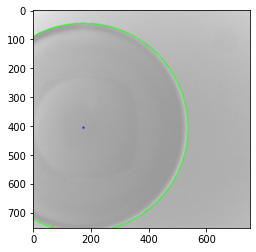

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000157
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000158
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000159
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000160
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000161
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000162
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000163
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000164
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000165
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000166
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000167
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000168
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000169
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000170
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000171
Loaded image fr

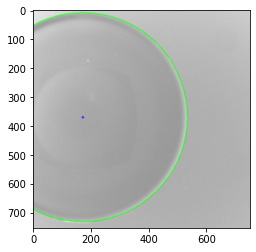

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000201
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000202
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000203
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000204
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000205
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000206
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000207
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000208
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000209
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000210
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000211
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000212
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000213
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000214
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000215
Loaded image fr

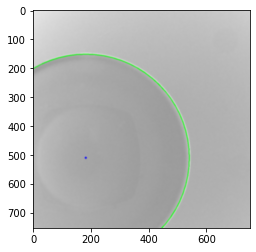

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000224
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000225
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000226
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000227
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000228
x,y: 252 234


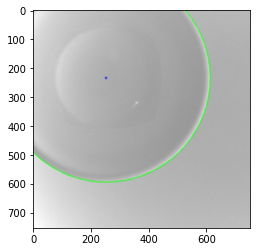

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000229
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000230
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000231
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000232
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000233
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000234
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000235
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000236
x,y: 62 392


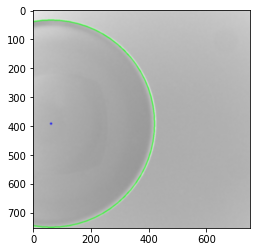

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000237
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000238
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000239
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000240
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000241
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000242
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000243
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000244
x,y: 2 420


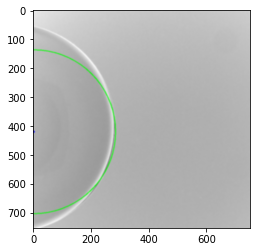

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000245
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000246
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000247
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000248
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000249
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000250
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000251
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000252
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000253
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000254
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000255
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000256
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000257
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000258
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000259
Loaded image fr

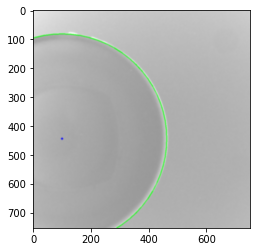

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000299
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000300
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000301
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000302
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000304
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000305
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000306
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000307
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000309
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000310
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000311
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000312
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000313
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000314
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000315
Loaded image fr

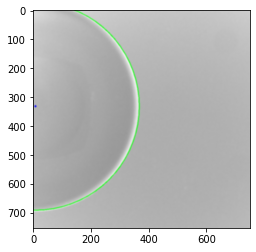

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000395
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000396
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000397
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000398
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000400
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000401
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000402
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000403
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000404
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000405
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000406
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000407
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000408
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000409
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000410
Loaded image fr

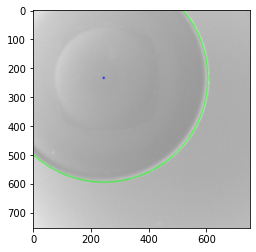

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000476
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000477
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000478
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000479
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000480
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000481
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000482
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000483
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000484
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000485
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000486
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000487
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000488
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000490
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000491
Loaded image fr

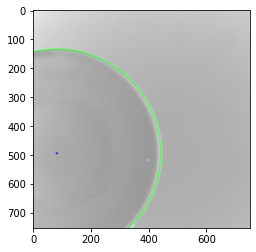

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000523
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000524
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000525
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000526
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000527
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000528
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000529
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000530
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000531
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000532
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000533
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000534
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000535
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000536
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000537
Loaded image fr

<ipython-input-9-9d7c25a4a9f3>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "preprocess_XY" failed type inference due to: Untyped global name 'PCA': Cannot determine Numba type of <class 'abc.ABCMeta'>

File "<ipython-input-9-9d7c25a4a9f3>", line 38:
def preprocess_XY(images, labels):
    <source elided>
    
    pca = PCA(n_components=70)
    ^

  @jit
<ipython-input-9-9d7c25a4a9f3>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "preprocess_XY" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-9-9d7c25a4a9f3>", line 5:
def preprocess_XY(images, labels):
    <source elided>
    defectcount = reservedcount = normalcount = 0
    for element in labels:
    ^

  @jit
C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "preprocess_XY" was 

############# OVERALL ################
불량 갯수: 540
보류 갯수: 0
정상 갯수: 936

n pixels: 564750
grid search
grid.fit
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.676, total=   0.3s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.676, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.674, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.674, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.674, total=   0.2s
[CV] C=1, gamma=1e-10, kernel=rbf ....................................
[CV] ........ C=1, gamma=1e-10, kernel=rbf, score=0.676, total=   0.1s
[CV] C=1, gamma=1e-10, kernel=rbf ....................................
[CV] ........ C=1, gamma=1e-10, kernel=rbf, score=0.676, total=   0.1s
[CV] C=1, gamma=1e-10, kernel=rbf ....................................
[CV] ........ C=1, gamma=1e-10, kernel=rbf, score=0.674, total=   0.1s
[CV] C=1, gamma=1e-10, kernel=rbf ....................................
[CV] ........ C=1, gamma=1e-10, kernel=rbf, score=0.674, total=   0.1s
[CV] C=1, gamma=1e-10, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    4.9s finished


Testing
score:  0.6964769647696477


In [10]:
#                         SVM

#                         GRID SEARCH FOR PARAMETER OPTIMIZING
svm = SVC()
#kernels: 'rbf', 'poly','sigmoid'
parameters = [{'kernel': ['rbf'], 'gamma': [1e-1, 1e-10], 'C': [1, 10, 100, 1000]}]
                    #{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

directory = os.getcwd() + "\AllLenses"


path_list =[]

#path1 = directory + "\Allframedata"
#path2 = directory + "\Allframedata2"
#path2 = directory + "\Allframedata3"
path_list.append(directory + "\Allframedata1")
#path_list.append(directory + "\Allframedata4")
#path_list.append(directory + "\Allframedata5")
#path_list.append(directory + "\Allframedata6")
#path_list.append(directory + "\Allframedata4")

for path in path_list:
    folders = []
    subject_folder = os.scandir(path)
    print("Files and Directories in '% s'" % path) 

    for file in subject_folder: 
        if file.is_dir() or file.is_file(): #중간중간에 파일이 빠져있음
            folders.append(file.name)
            #print("There is folder:", file.name)

    x, y = getImagesandLabels(path, folders)
    print("# of images", len(x))
    print("# of labels", len(y))
    #datagen.fit(x)
    #for X_batch, Y_batch in datagen.flow(tuple_input, y, batch_size=25): # these are chunks of 32 samples
    X_train, Y_train, X_test, Y_test = preprocess_XY(x, y)
    print("grid search")
    grid = GridSearchCV(svm, parameters, verbose=3)
    print("grid.fit")
    grid.fit(X_train, Y_train) #grid search learning the best parameters
    print("grid done")

    print (grid.best_params_)

    #Now we train the best estimator in the full dataset
    print("training svm")
    best_svm = grid.best_estimator_
    best_svm.fit(X_train , Y_train)
    print("svm done")

print("Testing")
print("score: ", best_svm.score(X_test, Y_test,))